## Install Additional Libraries

In [4]:
!pip install sentence-transformers
!pip install umap-learn hdbscan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import Libraries

In [5]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_20newsgroups, fetch_rcv1
from sentence_transformers import SentenceTransformer
import umap
import hdbscan
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import metrics

## Import Dataset

In [6]:
data = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))['data']

In [7]:
data[0]

'I am a little confused on all of the models of the 88-89 bonnevilles.\nI have heard of the LE SE LSE SSE SSEI. Could someone tell me the\ndifferences are far as features or performance. I am also curious to\nknow what the book value is for prefereably the 89 model. And how much\nless than book value can you usually get them for. In other words how\nmuch are they in demand this time of year. I have heard that the mid-spring\nearly summer is the best time to buy.'

## Generate Document Embeddings Using BERT

In [8]:
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(data, show_progress_bar=True)

Batches:   0%|          | 0/236 [00:00<?, ?it/s]

In [9]:
pd.DataFrame(embeddings).to_csv("./embeddings.csv", index=False)

In [10]:
embeddings = pd.read_csv("./embeddings.csv")

## Clustering

### Umap - Dimenionality Reduction

In [172]:
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric = 'cosine').fit_transform(embeddings)

### HDBSCAN - Clustering Documents

In [173]:
cluster = hdbscan.HDBSCAN(min_cluster_size=2,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

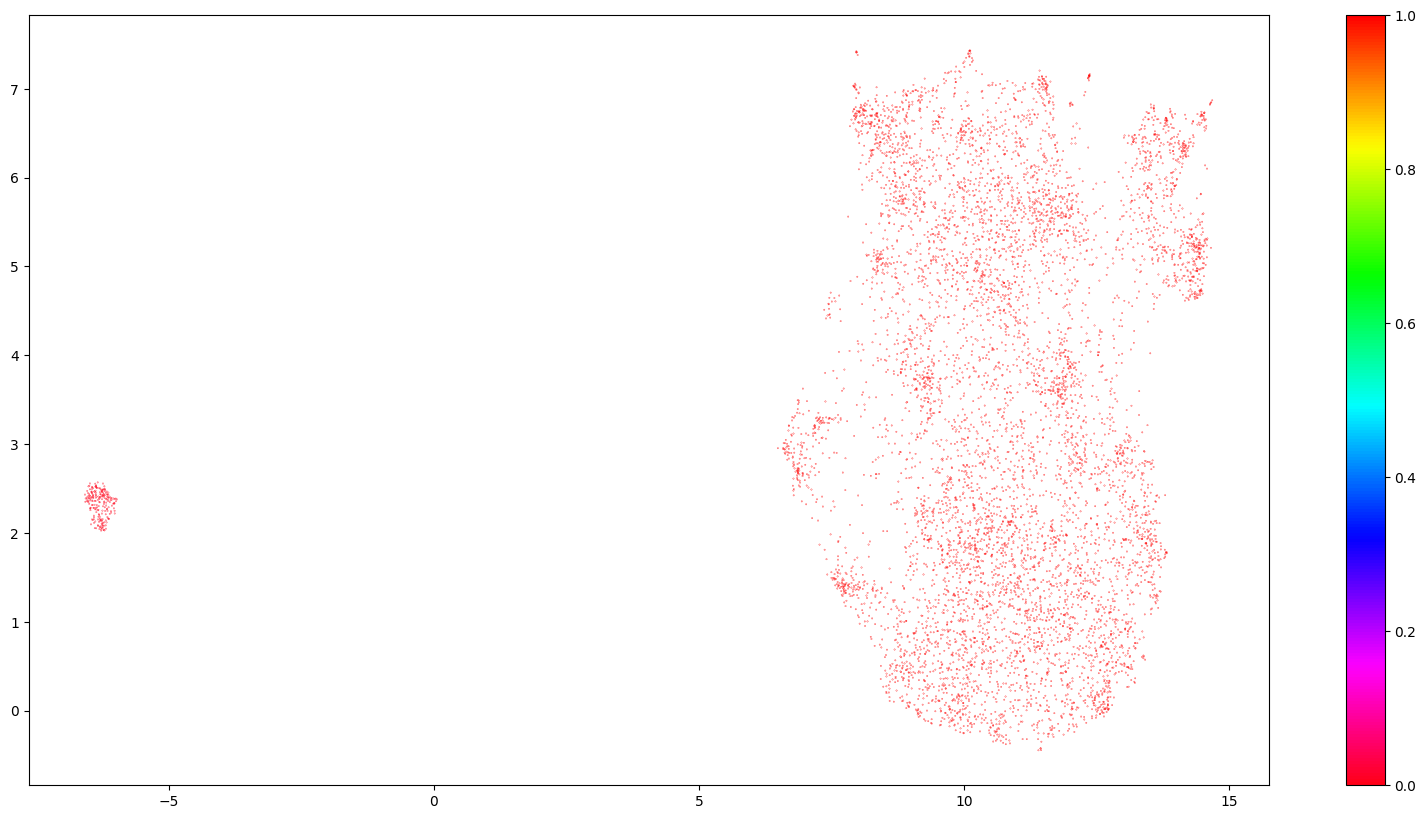

In [174]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

## Topic Creation

In [175]:
docs_df = pd.DataFrame(data, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [187]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

In [188]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=40)
topic_sizes = extract_topic_sizes(docs_df)
topic_sizes

,Topic,Size
1,1,7316
0,0,216


## Topic Reduction

In [189]:
# for i in range(20):
#     # Calculate cosine similarity
#     similarities = cosine_similarity(tf_idf.T)
#     np.fill_diagonal(similarities, 0)

#     # Extract label to merge into and from where
#     topic_sizes = docs_df.groupby(['Topic']).count().sort_values("Doc", ascending=False).reset_index()
#     topic_to_merge = topic_sizes.iloc[-1].Topic
#     topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1

#     # Adjust topics
#     docs_df.loc[docs_df.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
#     old_topics = docs_df.sort_values("Topic").Topic.unique()
#     map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
#     docs_df.Topic = docs_df.Topic.map(map_topics)
#     docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

#     # Calculate new topic words
#     m = len(data)
#     tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m)
#     top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)

# topic_sizes = extract_topic_sizes(docs_df)
# topic_sizes

In [190]:
topic_sizes

,Topic,Size
1,1,7316
0,0,216


In [191]:
len(topic_sizes)

2

In [192]:
topics = []

# Iterate over the top-N words for each topic
for top_words in top_n_words:
    topic_size = len(top_n_words[top_words])  # Get the number of words for the current topic
    topic = top_n_words[top_words][:topic_size]  # Select all the words for the topic
    x = [i[0] for i in topic]
    topics.append(x)

# Print the topics
for topic in topics:
    print(topic)


['ken', 'ÿhooked', 'dobson', 'dobbs', 'dobermans', 'dobkin', 'dobly', 'dobrica', 'doby', 'docket', 'dobyns', 'doc', 'docialists', 'docile', 'dock', 'docked', 'dobb', 'dob', 'doall', 'doa', 'do_up', 'do_right', 'do_red', 'do_not_propogate', 'do_middle', 'do_left', 'do_green', 'do_exit', 'do_down', 'do_blue', 'do8', 'do3', 'do0z3kfh', 'dockery', 'docking', 'dnz', 'documention', 'docuementation', 'document', 'documentary']
['don', 'like', 'just', 'people', 'know', 'think', 'time', 'use', 'does', 'new', 'god', 'good', 'way', 'make', 'edu', 've', 'did', 'used', 'say', 'right', 'want', '10', 'said', 'windows', 'need', 'work', 'problem', 'file', 'dos', 'really', 'believe', 'using', '00', 'going', 'image', 'point', 'software', 'information', 'read', 'help']


In [193]:
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary

In [194]:
dictionary = Dictionary(topics)

# Create a corpus from the list of topics
corpus = [dictionary.doc2bow(topic) for topic in topics]

# Create a CoherenceModel object with the corpus and dictionary
coherence_model = CoherenceModel(
    topics=topics,
    corpus=corpus,
    dictionary=dictionary,
    texts=topics,
    coherence='c_v'  # Specify the coherence measure, e.g., 'c_v', 'u_mass', 'c_uci', 'c_npmi'
)

# Calculate the coherence score
coherence_score = coherence_model.get_coherence()

# Print the coherence score
print("Coherence Score:", coherence_score)

Coherence Score: 1.0000000000000002


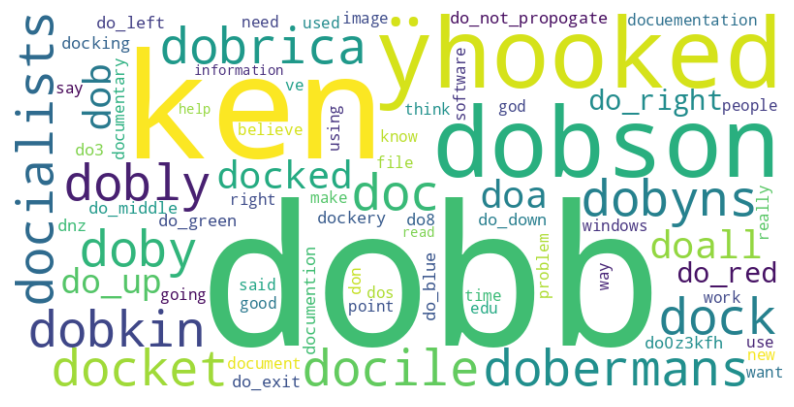

In [195]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Concatenate the top words from all topics
all_words = ''
for topic in topics:
  for word in topic:
    all_words += word
    all_words += " "

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [196]:
all_words

'ken ÿhooked dobson dobbs dobermans dobkin dobly dobrica doby docket dobyns doc docialists docile dock docked dobb dob doall doa do_up do_right do_red do_not_propogate do_middle do_left do_green do_exit do_down do_blue do8 do3 do0z3kfh dockery docking dnz documention docuementation document documentary don like just people know think time use does new god good way make edu ve did used say right want 10 said windows need work problem file dos really believe using 00 going image point software information read help '

In [197]:
from sklearn.metrics import silhouette_samples

# Calculate the silhouette coefficients
silhouette_values = silhouette_samples(umap_embeddings, cluster.labels_)

# Calculate the average silhouette coefficient
average_silhouette_score = np.mean(silhouette_values)

# Print the average silhouette coefficient
print("Average Silhouette Score:", average_silhouette_score)

Average Silhouette Score: 0.84804696
